### 필요패키지 설치 및 로드




In [1]:
# 사용 패키지 로드
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder # 인코딩용
from imblearn.over_sampling import SMOTE # 오버샘플링
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn import linear_model

def evalBinaryClassifier(model,x, y, labels=['Positives','Negatives']):
        '''
        Visualize the performance of  a Logistic Regression Binary Classifier.

        Displays a labelled Confusion Matrix, distributions of the predicted
        probabilities for both classes, the ROC curve, and F1 score of a fitted
        Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts

        Parameters
        ----------
        model : fitted scikit-learn model with predict_proba & predict methods
            and classes_ attribute. Typically LogisticRegression or 
            LogisticRegressionCV

        x : {array-like, sparse matrix}, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples
            in the data to be tested, and n_features is the number of features

        y : array-like, shape (n_samples,)
            Target vector relative to x.

        labels: list, optional
            list of text labels for the two classes, with the positive label first

        Displays
        ----------
        3 Subplots

        Returns
        ----------
        F1: float
        '''
        #model predicts probabilities of positive class
        p = model.predict_proba(x)
        if len(model.classes_)!=2:
            raise ValueError('A binary class problem is required')
        if model.classes_[1] == 1:
            pos_p = p[:,1]
        elif model.classes_[0] == 1:
            pos_p = p[:,0]

        #FIGURE
        plt.figure(figsize=[15,4])

        #1 -- Confusion matrix
        cm = confusion_matrix(y,model.predict(x))
        plt.subplot(131)
        ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                    annot_kws={"size": 14}, fmt='g')
        cmlabels = ['True Negatives', 'False Positives',
                  'False Negatives', 'True Positives']
        for i,t in enumerate(ax.texts):
            t.set_text(t.get_text() + "\n" + cmlabels[i])
        plt.title('Confusion Matrix', size=15)
        plt.xlabel('Predicted Values', size=13)
        plt.ylabel('True Values', size=13)

        #2 -- Distributions of Predicted Probabilities of both classes
        df = pd.DataFrame({'probPos':pos_p, 'target': y})
        plt.subplot(132)
        plt.hist(df[df.target==1].probPos, density=True, 
                 alpha=.5, color='green',  label=labels[0])
        plt.hist(df[df.target==0].probPos, density=True, 
                 alpha=.5, color='red', label=labels[1])
        plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
        plt.xlim([0,1])
        plt.title('Distributions of Predictions', size=15)
        plt.xlabel('Positive Probability (predicted)', size=13)
        plt.ylabel('Samples (normalized scale)', size=13)
        plt.legend(loc="upper right")

        #3 -- ROC curve with annotated decision point
        fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
        roc_auc = auc(fp_rates, tp_rates)
        plt.subplot(133)
        plt.plot(fp_rates, tp_rates, color='green',
                 lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
        #plot current decision point:
        tn, fp, fn, tp = [i for i in cm.ravel()]
        plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', size=13)
        plt.ylabel('True Positive Rate', size=13)
        plt.title('ROC Curve', size=15)
        plt.legend(loc="lower right")
        plt.subplots_adjust(wspace=.3)
        plt.show()
        #Print and Return the F1 score
        tn, fp, fn, tp = [i for i in cm.ravel()]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2*(precision * recall) / (precision + recall)
        printout = (
            f'Precision: {round(precision,2)} | '
            f'Recall: {round(recall,2)} | '
            f'F1 Score: {round(F1,2)} | '
        )
        print(printout)
        return F1

In [26]:
def demo_report(model,X,y,title):
    y_pred = model.predict(X)
    inb = classification_report(y,y_pred)
    repeat = "-" *50
    print(repeat)      
    print(f"Classification Report: {title}")
    print(repeat)      
    print("\n")
    print(f"{inb}")
    print(repeat)
    print(repeat)      
    print(f"Confusion Matrix & Roc Curve")
    print(repeat)
    F1 = evalBinaryClassifier(model,X,y)

## 문제정의

### GOMS 조사개요
최근 청년층 고용문제 특히, 대학 졸업자의 고용 악화가 큰 사회적 문제가 되고 있다. 대졸 청년층의 취업난은 개인과 가정을 힘들게 하고, 사회경제적 손실을 넘어 사회병리적인 문제로 심화되고 있다.

 
이렇듯 장기간 지속되는 고학력 청년실업 문제를 풀려면, 대학 졸업 후 노동시장의 진입과 이행에 대한 다각적인 정책이 필요하다.  졸업시점의 경제상황에 따라 대졸자의 노동시장진입 및 노동시장 성과에 미치는 효과는 상당한 차이를 보이기에 이를 정확하게 파악하는 것이 우선이다. 2009년 이후 청년층 대졸자의 급감, 대학구조개편, 교육정보 공시제도 시행 등의 고등교육 정책이 가시화됨에 따라 대학교육서비스 시장은 상당한 변화가 있을 것으로 예상된다.

이러한 변화에 부응하고 정책적 수요를 충족시키기 위한 대졸자들의 노동시장 진입과 정착 과정에 대한 실증적 자료가 요구됨에 따라  『대졸자직업이동경로조사』를 실시하게 되었다.



### 분석목적


## 2. 가설, 평가지표, Baseline 선택

In [4]:
!pwd

/c/Project/project-turnover-behavior/notebooks


In [2]:
# 원본데이터 불러오기
import pandas as pd

df = pd.read_csv('../data/GP18_2019_use.csv',encoding='cp949')
df.columns = df.columns.str.lower()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (43,279) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,g181pid,g181branch,g181found,g181course,g181daynight,g181majorcat,g181dpmt,g181dpmt_n,g181major,g181major_n,...,g181p041,g181r001,g181r002,g181r003,g181r023,g181r024,g181r025,g181r026,g181r027,g181wt
0,100013,1,3,3,2,1,C010101,일본어,C01010100027,비즈니스일본어과,...,2,2,NaN,2,100,0,0,0,1.0,33.641815
1,100018,1,3,3,1,1,C010101,일본어,C01010100013,일본어과,...,2,2,NaN,2,10,0,0,20,NaN,21.997140
2,100019,1,3,3,1,1,C010101,일본어,C01010100013,일본어과,...,1,2,NaN,2,40,0,0,38,3.0,21.997140
3,100034,1,3,3,1,1,C010101,일본어,C01010100005,관광일어과,...,2,1,300.0,2,100,10,0,30,1.0,35.853258
4,100036,1,3,3,1,1,C010101,일본어,C01010100005,관광일어과,...,2,1,1008.0,2,30,0,0,0,1.0,20.945343


In [ ]:
df.shape

(18163, 290)

### 가설

- 비정규직이 이직준비가능성이 높을 것이다.
- 출근에 걸리는 시간이 이직준비 여부에 영향을 미칠 것이다.



## 3. Data Preprocessing

In [7]:
# 지난 4주간 주로 한 일
df.g181sq001.value_counts()

1     12281
9      1961
7      1656
3       667
8       589
14      557
4       134
2       109
10       93
5        39
6        33
11       16
12       13
15        9
13        6
Name: g181sq001, dtype: int64

In [ ]:
# 컬럼g 수 확인
len(df.columns)

290

In [ ]:
df.columns[:10]

Index(['g181pid', 'g181branch', 'g181found', 'g181course', 'g181daynight',
       'g181majorcat', 'g181dpmt', 'g181dpmt_n', 'g181major', 'g181major_n'],
      dtype='object')

In [30]:
df['g181a021']

0        2.0
1        NaN
2        5.0
3        1.0
4        1.0
        ... 
18158    NaN
18159    1.0
18160    4.0
18161    NaN
18162    1.0
Name: g181a021, Length: 18163, dtype: float64

In [4]:

def subset_df(df):
    worker_df = df[df['g181sq006'].notnull()] # 근로자(일의 종류)
    
    
    # 임금종사자 여부
    """
    1	타인 또는 회사에 고용되어 보수(돈)를 받고 일한다.(직장, 아르바이트 등 포함)
    2	내 사업을 한다.
    3	가족의 일을 돈을 받지 않고 돕는다.
    """
    worker_cond = [
        (worker_df['g181sq006'] == 1), 
        (worker_df['g181sq006'] == 2),
        (worker_df['g181sq006'] == 3)
    ]
    
    worker_choices = ['employed','self_employed','non_paid']
    
    worker_df['worker_type'] = np.select(worker_cond, worker_choices,default=None)
    
    # 임금근로자만 추출
    worker_df = worker_df[worker_df['worker_type'] == 'employed'] 
    
    
    # 상용 근로자만 추출
    """
    1	상용근로자
    2	상용근로자 외 임시,일용직
    """
    regular_cond = [worker_df['g181a021'] == 1,
                    worker_df['g181a021'] != 1]
    
    
    worker_df['regular_worker'] = np.select(regular_cond, ['yes','no'],default=None)
    

    worker_df = worker_df[worker_df['regular_worker'] == 'yes']
    
    
    return worker_df

In [5]:
worker_df = subset_df(df)

C:\Users\yjinh\AppData\Local\Temp/ipykernel_20416/1109889356.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_df['worker_type'] = np.select(worker_cond, worker_choices,default=None)


In [50]:
print(eng_df.shape)
print(eng_df['g181d001'].value_counts())
print(eng_df['g181d001'].unique())

(10525, 292)
1.0    2172
Name: g181d001, dtype: int64
[nan  1.]


### 데이터 확인용 전처리


In [ ]:
"""
임금,비임금, 무급종사자
기본적으로 임금종사자만 분석대상으로 함
"""

df.g181sq006.value_counts()

1.0    12647
2.0      563
3.0      103
Name: g181sq006, dtype: int64

In [ ]:
## SQ4. 임금,비임금, 무급종사자
f1_df=df[df['g181sq006'].notnull()]
f1_df.g181sq006.unique()

array([1., 2., 3.])

In [ ]:
# 임금종사자 여부
conditions = [
    (f1_df['g181sq006'] == 1),
    (f1_df['g181sq006'] == 2),
    (f1_df['g181sq006'] == 3)]
choices = ['emoloyed', 'self_employed', 'non_paid']
f1_df['emp_status'] = np.select(conditions, choices, default='nan')
print(f1_df.head())

   g181pid  g181branch  g181found  ...  g181r027     g181wt     emp_status
0   100013           1          3  ...       1.0  33.641815       emoloyed
2   100019           1          3  ...       3.0  21.997140  self_employed
3   100034           1          3  ...       1.0  35.853258       emoloyed
4   100036           1          3  ...       1.0  20.945343       emoloyed
5   100047           1          3  ...       1.0  19.420393       emoloyed

[5 rows x 291 columns]


In [ ]:
f1_df.shape

(13313, 291)

In [ ]:
f1_df.emp_status.value_counts()

emoloyed         12647
self_employed      563
non_paid           103
Name: emp_status, dtype: int64

In [ ]:
f1_df = pd.get_dummies(f1_df,columns = ['emp_status'])

In [ ]:
employed_ck=f1_df[f1_df['emp_status_emoloyed']==1]

In [ ]:
# 임금근로자
employed_ck.g181a297.value_counts()

2.0    9493
1.0    3154
Name: g181a297, dtype: int64

In [ ]:
# 임금근로자 종사상 지위
# 상용근로자만 분석대상으로 
employed_ck["g181a021"].value_counts()

1.0    10525
2.0     1957
3.0      165
Name: g181a021, dtype: int64

In [ ]:
fin_emp = employed_ck[employed_ck.g181a021==1]

In [ ]:
# 타겟 변수 
target = 'g181a297'

In [ ]:
# 상용근로자의 타겟변수 비율
fin_emp[target].value_counts(normalize=True)

2.0    0.784988
1.0    0.215012
Name: g181a297, dtype: float64

fin_emp를 분석데이터로 사용

In [ ]:
# 상용 근로자 기준으로 변수 선택
fin_emp.shape

(10525, 295)

In [ ]:
# E1. 현재 일자리와 첫 일자리를 제외하고 다른 일자리를 다닌 경험 유무
# 1인 경우 twice
fin_emp["g181e001"].value_counts()

2.0    10039
1.0      486
Name: g181e001, dtype: int64

In [ ]:
fin_emp["g181d001"].value_counts()

1.0    2172
Name: g181d001, dtype: int64

In [ ]:
fin_emp.g181d006.unique()

array([nan,  2.,  1.])

In [ ]:
# 현직장이 첫직장이 아닌경우 나타내는 변수 추가
# df['color'] = np.where(df['Set']=='Z', 'green', 'red')

# cond_turnover = (fin_emp['g181d006']==2) 

fin_emp['turnover_once'] = np.where(fin_emp['g181d001'].isnull()==True, 0, fin_emp['g181d001'])

In [ ]:
# 현 직장이 두번째 직장인 경우
fin_emp["turnover_once"].value_counts()

0.0    8353
1.0    2172
Name: turnover_once, dtype: int64

In [6]:
# 이직 경험 빈도를 나타내는 변수 추가
"""
0 : 첫직장 전 취업 한적 없음
1 : 알바 경험만 있음
2 : 1번 이직함
3 : 2번 이상 이직함


g181e001


"""

#fin_emp['turnover_once'] = np.where(fin_emp['g181d001'].isnull()==True, 0, fin_emp['g181d001'])

conditions = [
    (worker_df['g181d001'].isnull()==True ), # 첫 직장 전 취업한적 없음(알바포함)
    (worker_df['g181d001']==1) & (fin_emp['g181d006']==1), # 알바 경험 있음
    (worker_df['g181d001']==1) & (fin_emp['g181d006']==2) & (fin_emp['g181e001']==2), # 전직장 있음, 1번이직
    (worker_df['g181e001']== 1)] # 전직장 2개 이상 있음
choices = [0, 1, 2, 3]


fin_emp['turnover_ex'] = np.select(conditions, choices,default=3)

fin_emp['turnover_ex'].value_counts()

NameError: name 'fin_emp' is not defined

In [ ]:
# 알바제외 근로경험
fin_emp['turnover'] = np.where(fin_emp['turnover_ex'].isin([0,1]),0,1)

In [ ]:
# 알바제외 근로경험 변수
fin_emp.turnover.value_counts()

0    8686
1    1839
Name: turnover, dtype: int64

#### 변수리스트 확인

In [ ]:
col_list = [
       'g181pid', # id 
       'turnover_ex', # 이직경험 빈도
       'turnover', # 알바제외 근로경험
       'g181majorcat', # 전공계열
       'g181sex', # 성별 
       'g181birthy', # 출생년
       'g181age', # 연력
       'g181graduy', # 졸업년
### 사업체 관련 // 현일자리 시작 연월 사용 불가능    
        'g181a001',  # 현일자리 시작년
        'g181a002', # 현일자리  시작월
        'g181a004_10', # 일자리 산업 대분류
        'g181a010', # 기업체 종사자 수
        'g181a011', # 사업체 종사자 수
        'g181a018', # 출근시간_시간
        'g181a019', # 출근시간_분
        'g181a116', # 주당 정규 근로일
        'g181a117', # 주당정규 근로시간
        'g181a118', # 주당초과 근로시간
        'g181a119', # 월평균 후일근로
        'g181a020', # 사업체형태
       'g181a022',     # 정규직 비정규직 여부
### 혜택관련
        'g181a390',     # 일자리 형태 자발, 비자발 여부
        'g181a035' ,    # 교대제 여부
        'g181a038',     # 퇴직금 제공 여부
        'g181a039',     # 제공여부 2- 유급휴가
        'g181a043',     #  6- 육아휴직
        'g181a045',     # 8- 시간 외 수당
        'g181a046',     # 9- 상여금
        'g181a048',     # 11- 유급주휴
        'g181a392',     # 12- 산전후휴가
        'g181a120',     # 급여 형태 구분
        'g181a122',     # 월 평균 근로소득
        'g181a126',     # 만족도-임금
        'g181a127',     # 만족도-고용안정성
        'g181a128',     # 만족도-직무내용
        'g181a129',     # 만족도-근무환경
        'g181a130',     # 만족도-노동시간
        'g181a131',     # 만족도-발전가능성
        'g181a132',     # 만족도-인간관계
        'g181a133',     # 만족도-복리후생
        'g181a134',     # 만족도-인사체계
        'g181a135',     # 만족도-사회적평판-일
        'g181a136',     # 만족도-자율성 및 권한
        'g181a137',     # 만족도-일자리-사회적 평판
        'g181a138',     # 만족도-적성흥미일치도
        'g181a139',     # 만족도-직무관련 교육
        'g181a140',     # 만족도-일자리_전반적만족도
        'g181a141',     # 만족도-업무_전반적만족도
        'g181a142',     # 교육수준-일수준일치정도
        'g181a143',     # 일기술수준-본인기술수준일치정도
        'g181a144',     # 주전공일치정도
        'g181a146',     # 전공지식업무도움정도
        'g181a158',     # 보험-국민연금
        'g181a159',     # 보험-특수직역연금
        'g181a160',     # 보험-건강보험
        'g181a161',     # 보험-고용보험
        'g181a162',     # 보험-산재보험
        'g181a189',     # 구직활동경험기간-개월
        'g181a283',     # 다른일자리제의여부
        'g181a285',     # 적응시어려움여부
        'g181a297',     # 이직준비 여부: target
        'g181g001',     # 대학원 경험유무
        'g181l001',     # 취업훈련경험유무
        'g181q001',     # 현재 견강상태
        'g181q004',     # 흡연여부
        'g181q006',     # 음주빈도
        'g181q015',     # 삶의만족도-개인적 측면
        'g181q016',     # 삶의만족도-관계적 측면
        'g181q017',     # 삶의만족도-소속집단
        'g181q018',     # 감정빈도-즐거운
        'g181q019',     # 감정빈도-행복한
        'g181q020',     # 감정빈도-편안한
        'g181q021',     # 감정빈도-짜증나는
        'g181q022',     # 감정빈도-부정적인
        'g181q023',     # 감정빈도-무기력한
        'g181p001',     # 혼인여부
        'g181p008',     # 부양자녀 유무
        'g181p036',     # 부모님 자산규모
        'g181p046',     # 거주형태
        'g181p041'      # 경제적 지원여부
]

In [ ]:
len(col_list)

80

In [ ]:
# 필요컬럼 선택
fin_df = fin_emp[col_list]
fin_df.shape

(10525, 80)

In [ ]:
fin_df.columns.duplicated() # 중복컬럼 확인

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
# 결측치 확인
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fin_df.isna().sum())

g181pid            0
turnover_ex        0
turnover           0
g181majorcat       0
g181sex            0
g181birthy         0
g181age            0
g181graduy         0
g181a001           0
g181a002           0
g181a004_10        0
g181a010           0
g181a011           0
g181a018           0
g181a019           0
g181a116           0
g181a117           0
g181a118           0
g181a119           0
g181a020           0
g181a022           0
g181a390           0
g181a035           0
g181a038           0
g181a039           0
g181a043           0
g181a045           0
g181a046           0
g181a048           0
g181a392           0
g181a120           0
g181a122           0
g181a126           0
g181a127           0
g181a128           0
g181a129           0
g181a130           0
g181a131           0
g181a132           0
g181a133           0
g181a134           0
g181a135           0
g181a136           0
g181a137           0
g181a138           0
g181a139           0
g181a140           0
g181a141     

In [ ]:
# 결측값 0으로 채움 (구직활동기간이 0이기 때문에)
fin_df.g181a189 =fin_df.g181a189.fillna(0)

In [ ]:
fin_df.g181a189.unique()

array([ 3.,  0.,  7.,  1.,  6., 12.,  2., 10.,  4., 18.,  8.,  9.,  5.,
       19., 15., 60., 14., 13., 24., 11., 36., 16., 17., 28., 30., 48.,
       20., 22., 32., 21., 23., 34., 40., 50.])

In [ ]:
# 카디널리티 확인
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fin_df.nunique())

g181pid         10525
turnover_ex         4
turnover            2
g181majorcat        7
g181sex             2
g181birthy         48
g181age           333
g181graduy          2
g181a001           34
g181a002           12
g181a004_10        21
g181a010           10
g181a011           10
g181a018            3
g181a019           38
g181a116           10
g181a117           68
g181a118           38
g181a119           10
g181a020            8
g181a022            2
g181a390            2
g181a035            2
g181a038            3
g181a039            3
g181a043            3
g181a045            3
g181a046            3
g181a048            3
g181a392            3
g181a120            6
g181a122          314
g181a126            5
g181a127            5
g181a128            5
g181a129            5
g181a130            5
g181a131            5
g181a132            5
g181a133            5
g181a134            5
g181a135            5
g181a136            5
g181a137            5
g181a138            5
g181a139  

### 분석에 사용할 변수만 선택


- id
- 대학원 졸 유무
- 정규직 비정규직 유무
- 첫 직장 유무
- 성별
- 나이
- 근속연수
- 부양가족 여부
- 결혼 여부
- 지원
- 연봉
- 학과


In [ ]:

# 칼럼 rename용 dictionalry 만들기
# numeric , cat , one hot , date  구분 매핑
# 

col_dic =  {
      'g181pid':'id', # id 
       'turnover_exp':'turnover_exp', # 이직경험 빈도
       'worrk_exp':'work_exp', # 알바제외 근로경험
       'g181majorcat':'majorcat_cat', # 전공계열
       'g181sex':'sex_cat', # 성별   
       'g181birthy':'birth_date', # 출생년
       'g181age':'age_num', # 연령
       'g181graduy':'graduy_date', #졸업년
### 사업체 관련       
        'g181a001':'year_start_date', # 현일자리 시작년
        'g181a002':'month_start_date', # 현일자리 시작월
        'g181a004_10':'ind_cat', # 일자리 산업 대분류
        'g181a010':'corp_worker_num', # 기업체 종사자 수
        'g181a011':'biz_worker_cat', # 사업체 종사자 수
        'g181a018':'tw_hour', # 출근시간_시간
        'g181a019':'tw_min', # 출근시간_분
        'g181a116':'workday_num', # 주당 정규 근로일
        'g181a117':'worktime_num', # 주당정규 근로시간
        'g181a118':'worktime_ex_num', # 주당초과 근로시간
        'g181a119': 'holy_work_num', # 월평균 휴일근로
        'g181a020': 'biztype_cat', # 사업체형태
       'g181a022':'regular_cat',     # 정규직 비정규직 여부
### 혜택관련
        'g181a390':'voluntary_cat',     # 일자리 형태 자발, 비자발 여부
        'g181a035':'shift_cat' ,    # 교대제 여부
        'g181a038':'pension_cat',     # 퇴직금 제공 여부
        'g181a039':'payed_vc_cat',     # 제공여부 2- 유급휴가
        'g181a043':'maternitylv_cat',     #  6- 육아휴직
        'g181a045':'overtime_pay_cat',     # 8- 시간 외 수당
        'g181a046':'bonus_cat',     # 9- 상여금
        'g181a048':'weely_hl_cat',     # 11- 유급주휴
        'g181a392':'baby_vc_cat',     # 12- 산전후휴가
        'g181a120':'wage_type_cat',     # 급여 형태 구분
        'g181a122':'month_wage_num',     # 월 평균 근로소득
        'g181a126':'sat_wage_num',     # 만족도-임금
        'g181a127':'sat_stable_num',     # 만족도-고용안정성
        'g181a128':'sat_work_num',     # 만족도-직무내용
        'g181a129':'sat_envi_num',     # 만족도-근무환경
        'g181a130':'sat_wt_num',     # 만족도-노동시간
        'g181a131':'sat_potential_num',     # 만족도-발전가능성
        'g181a132':'sat_relation_num',     # 만족도-인간관계
        'g181a133':'sat_welfare_num',     # 만족도-복리후생
        'g181a134':'sat_hr_num',     # 만족도-인사체계
        'g181a135':'sat_rep1_num',     # 만족도-사회적평판-일
        'g181a136':'sat_auto_num',     # 만족도-자율성 및 권한
        'g181a137':'sat_rep2_num',     # 만족도-일자리-사회적 평판
        'g181a138':'sat_fit_num',     # 만족도-적성흥미일치도
        'g181a139':'sat_edu_num',     # 만족도-직무관련 교육
        'g181a140':'sat_general_num',     # 만족도-일자리_전반적만족도
        'g181a141':'sat_work-general_num',     # 만족도-업무_전반적만족도
        'g181a142':'edu-fit_num',     # 교육수준-일수준일치정도
        'g181a143':'skill-fit_num',     # 일기술수준-본인기술수준일치정도
        'g181a144':'major-fit_num',     # 주전공일치정도
        'g181a146':'major_help_num',     # 전공지식업무도움정도
        'g181a158':'ins_1_num',     # 보험-국민연금
        'g181a159':'ins_2_num',     # 보험-특수직역연금
        'g181a160':'ins_3_num',     # 보험-건강보험
        'g181a161':'ins_4_num',     # 보험-고용보험
        'g181a162':'ins_5_num',     # 보험-산재보험
        'g181a189':'seeking_time_num',     # 구직활동경험기간-개월
        'g181a283':'adjust_difficulty_cat',     # 다른일자리제의여부
        'g181a285':'job_offer_cat',     # 적응시어려움여부
        'g181a297':'turnover_intention',     # 이직준비 여부: target
        'g181g001':'graduate_cat',     # 대학원 경험유무
        'g181l001':'train_cat',     # 취업훈련경험유무
        'g181q001':'health_num',     # 현재 견강상태
        'g181q004':'smoke_cat',     # 흡연여부
        'g181q006':'drink_num,',     # 음주빈도
        'g181q015':'lifesat_personal',     # 삶의만족도-개인적 측면
        'g181q016':'lifesat_relational',     # 삶의만족도-관계적 측면
        'g181q017':'lifesat_group',     # 삶의만족도-소속집단
        'g181q018':'emg_joy_num',     # 감정빈도-즐거운
        'g181q019':'emg_happy_num',     # 감정빈도-행복한
        'g181q020':'emg_comfort_num',     # 감정빈도-편안한
        'g181q021':'emb_irr_num',     # 감정빈도-짜증나는
        'g181q022':'emb_negative_num',     # 감정빈도-부정적인
        'g181q023':'emb_spiritless',     # 감정빈도-무기력한
        'g181p001':'marriage_cat',     # 혼인여부
        'g181p008':'child_cat',     # 부양자녀 유무
        'g181p036':'parent_asset_cat',     # 부모님 자산규모
        'g181p046':'livetype_cat',     # 거주형태
        'g181p041':'support_cat'      # 경제적 지원여부
}


len(col_dic)

80

In [ ]:
fin_df.columns = fin_df.columns.map(col_dic)

In [ ]:
fin_df.corp_worker_num.value_counts()

 9.0    2736
 3.0    1422
-1.0    1409
 6.0    1161
 5.0     926
 2.0     725
 4.0     623
 8.0     566
 7.0     511
 1.0     446
Name: corp_worker_num, dtype: int64

In [ ]:
fin_df.tw_hour.value_counts()

0.0    8339
1.0    2091
2.0      95
Name: tw_hour, dtype: int64

In [ ]:
# 모름 응답이 있는 컬럼 탐색
deal_col=fin_df.columns[fin_df.isin([-1]).any()].tolist()  # df.isin([response])

In [ ]:
deal_col

['ind_cat',
 'corp_worker_num',
 'biz_worker_cat',
 'wage_type_cat',
 'month_wage_num',
 'child_cat',
 'parent_asset_cat',
 'support_cat']

In [ ]:
for col in deal_col:
    print(fin_df[col].value_counts())

 3.0     2092
 16.0    1351
 13.0    1194
 17.0    1030
 10.0     945
 7.0      775
 15.0     721
 11.0     435
 6.0      397
 14.0     321
 8.0      309
 9.0      280
 19.0     218
 18.0     167
 4.0      118
 12.0      79
 5.0       54
 1.0       27
-1.0        8
 21.0       3
 2.0        1
Name: ind_cat, dtype: int64
 9.0    2736
 3.0    1422
-1.0    1409
 6.0    1161
 5.0     926
 2.0     725
 4.0     623
 8.0     566
 7.0     511
 1.0     446
Name: corp_worker_num, dtype: int64
 3.0    2086
 6.0    1509
 9.0    1308
 5.0    1257
 2.0    1024
 4.0     891
-1.0     641
 7.0     637
 1.0     615
 8.0     557
Name: biz_worker_cat, dtype: int64
 2.0    6613
 1.0    3828
 5.0      63
 4.0       9
-1.0       7
 3.0       5
Name: wage_type_cat, dtype: int64
200.0    1217
250.0     879
300.0     663
230.0     556
180.0     497
         ... 
415.0       1
27.0        1
303.0       1
311.0       1
112.0       1
Name: month_wage_num, Length: 314, dtype: int64
 2    10260
 1      260
-1       

In [ ]:
# parent asset , biz_worker_num  catecorical ordinal 처리 

In [ ]:
# 제거
fin_df.drop(columns='corp_worker_num',axis=1,inplace=True)

In [ ]:
# 월급 모르는 애들 제거
#fin_df[fin_df.month_wage_num==-1]

fin_df = fin_df.drop(fin_df[fin_df.month_wage_num==-1].index)

In [ ]:
# 샘플 수
fin_df.shape

(10518, 79)

### 파생변수 생성

- ~근무기간~ 
- ~변수 네이밍 필요~ 
- ~혜택제공여부~
- ~만족도~
- ~보험~
- ~삶의 만족도~
- ~출근시간~
- ~부정적 감정~
- ~긍정적 감정~

In [ ]:
# 근무기간(년) 변수 생성
fin_df['work_year'] = 2019-fin_df['year_start_date']
fin_df['work_year'][:10]

3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
9     1.0
10    2.0
11    1.0
12    1.0
14    0.0
Name: work_year, dtype: float64

In [ ]:
# 출근시간 분단위 변수 생성
fin_df['work_time_num'] = fin_df['tw_min'] + 60 * fin_df['tw_hour']
fin_df['work_time_num'][:10]

3     60.0
4     20.0
5     90.0
6     90.0
7     15.0
9     40.0
10    10.0
11    40.0
12    40.0
14    30.0
Name: work_time_num, dtype: float64

In [ ]:
# 보험 수 sum
insurances_col = [col for col in fin_df if col.startswith('ins') ] 
fin_df['insurances_num'] = 0

for cols in insurances_col:
    fin_df['temp'] = np.where(fin_df[cols]==1, 1, 0)
    fin_df['insurances_num'] += fin_df['temp']

print(fin_df['insurances_num'].unique())

[4 0 3 2 1]


In [ ]:
# 회사 전반적만족도
biz_sat_col = [col for col in fin_df if col.startswith('sat') ] 
fin_df['biz_sat'] = fin_df[biz_sat_col].sum(axis=1)

In [ ]:
# 긍정적 감정
pos_col = [col for col in fin_df if col.startswith('emg') ] 
fin_df['pos'] = fin_df[pos_col].sum(axis=1)


In [ ]:
# 부정적 감정
neg_col = [col for col in fin_df if col.startswith('emb') ] 
fin_df['neg'] = fin_df[neg_col].sum(axis=1)

In [ ]:
# 삶의 만족도 sum
life_sat_col = [col for col in fin_df if col.startswith('lifesat') ] 
fin_df['life_sat'] = fin_df[life_sat_col].sum(axis=1)

In [ ]:
# 혜택제공 변수 num
benefit_col  =['pension_cat',     # 퇴직금 제공 여부
        'payed_vc_cat',     # 제공여부 2- 유급휴가
        'maternitylv_cat',     #  6- 육아휴직
        'overtime_pay_cat',     # 8- 시간 외 수당
        'bonus_cat',     # 9- 상여금
        'weely_hl_cat',     # 11- 유급주휴
        'baby_vc_cat'] # 출산휴가

fin_df['benefit_num'] = 0

for cols in benefit_col:
    fin_df['temp'] = np.where(fin_df[cols]==1, 1, 0)
    fin_df['benefit_num'] += fin_df['temp']

In [ ]:
fin_df['benefit_num'].unique()

array([7, 5, 0, 4, 6, 2, 3, 1])

## Data Visualization

이직의도 비율

In [ ]:
fin_df['turnover_intention'] = np.where(fin_df['turnover_intention']==1,1,0)
target = 'turnover_intention'
fin_df[target].value_counts(normalize = True)

0    0.784845
1    0.215155
Name: turnover_intention, dtype: float64

In [ ]:
draw_df = fin_df

In [ ]:
gender_code = {1:'male', 2:'female'}
major_code = {1:'Human', 2:'Social', 3:'Edu', 4:'Engineer', 5:'Science',6:'Medinal',7:'Art'}
regular_code = {1:'비정규', 2:'정규'}
bizsize_code = {1:'1~4명', 2:'5~9명',3:'10~29명',
                4:'30~49명',5:'50~99명',6:'100~299명',
                7:'300~499명',8:'500~999명',9:'1000명이상',-1:'모름'}

draw_df = draw_df.replace({'sex_cat' : gender_code, 'majorcat_cat': major_code,'regular_cat':regular_code ,'biz_worker_cat':bizsize_code})

In [ ]:
fin_df['turnover_intention'] = fin_df['turnover_intention'].astype('category')

#### 전공계열에 따른 이직의도 차이

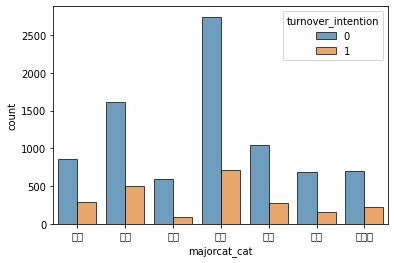

In [ ]:

sns.countplot(x='majorcat_cat', hue='turnover_intention',edgecolor="black", alpha=0.7, data=draw_df)

In [ ]:
pd.DataFrame(r)

turnover_intention
majorcat_cat turnover_intention                    
공학           0                             0.794954
             1                             0.205046
교육           0                             0.867733
             1                             0.132267
사회           0                             0.762353
             1                             0.237647
예체능          0                             0.757250
             1                             0.242750
의약           0                             0.809917
             1                             0.190083
인문           0                             0.746946
             1                             0.253054
자연           0                             0.787697
             1                             0.212303

#### 성별에 따른 이직의도 차이

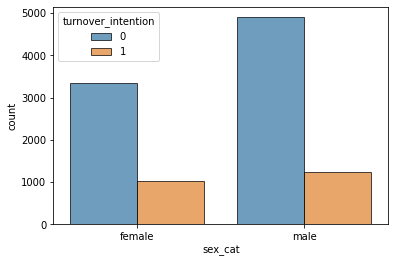

In [ ]:
sns.countplot(x='sex_cat', hue='turnover_intention',edgecolor="black", alpha=0.7, data=draw_df)

In [ ]:
sns.countplot(x='sex_cat', hue='turnover_intention',edgecolor="black", alpha=0.7, data=fin_df)

In [ ]:
r=draw_df.groupby(['majorcat_cat'])['turnover_intention'].value_counts(normalize=True)

## Modeling

In [ ]:
# 임시변수 삭제
fin_df.drop(columns='temp',axis=1,inplace=True)
fin_df.shape

(10518, 87)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


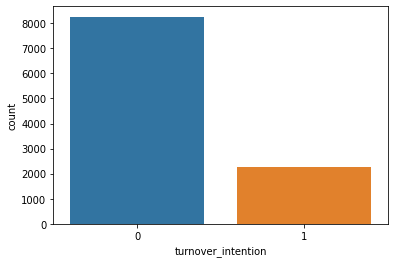

In [ ]:
# 클래스 불균형
%matplotlib inline
sns.countplot(fin_df[target])

### 데이터 분할

In [ ]:
train, test = train_test_split(fin_df,test_size=0.2,random_state=2)

In [ ]:
train, val = train_test_split(train,test_size=0.2,random_state=2)

In [ ]:
taget = 'turnover_intention'
features = train.drop(columns=[target]).columns

test_t = test[target]
test.drop(columns=target,axis=1,inplace=True)

print(train.shape)
print(val.shape)
print(test.shape)

(6731, 87)
(1683, 87)
(2104, 86)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_train = train[features] 
y_train = train[target]
X_val = val[features]
y_val = val[target]

### Baseline




In [ ]:
from sklearn.metrics import accuracy_score
#Mode
baseline =  y_train.mode()[0]

y_pred_baseline = [baseline] * len(train[target]) #

print('Baseline model 정확도(Accuracy) :', int(accuracy_score(train[target], y_pred).round(2) * 100),'%')

In [ ]:
y_pred_bs = [0] * len(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------------------------------------------
Classification Report: Baseline Model Report
--------------------------------------------------


              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1318
           1       0.00      0.00      0.00       365

    accuracy                           0.78      1683
   macro avg       0.39      0.50      0.44      1683
weighted avg       0.61      0.78      0.69      1683

--------------------------------------------------
--------------------------------------------------
Confusion Matrix & Roc Curve
--------------------------------------------------


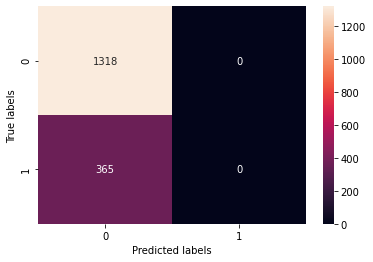

In [ ]:
# 기준모델
baseline_report(X_val,y_val,"Baseline Model Report")

In [ ]:
# confustion matrix plot function 
def plot_confusion_matrix(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

In [ ]:
def baseline_report(X,y,title):
    y_pred = [0] * len(X)
    inb = classification_report(y,y_pred)
    repeat = "-" *50
    print(repeat)      
    print(f"Classification Report: {title}")
    print(repeat)      
    print("\n")
    print(f"{inb}")
    print(repeat)
    print(repeat)      
    print(f"Confusion Matrix & Roc Curve")
    print(repeat)
    plot_confusion_matrix(y, y_pred)

### RandomForest

In [ ]:
# 범주형 처리할 피쳐 설정
# ordinal 할 피처
ordinal = ['biz_worker_cat','parent_asset_cat']

# onehot 할 피처
onehot = [col for col in fin_df if col.endswith('cat') ] 

onehot = [col for col in onehot if col not in ordinal ]


In [ ]:
# Classweight  계산 
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True,cols=onehot),
    OrdinalEncoder(cols=ordinal) ,
    SimpleImputer(), 
    StandardScaler(), 
    RandomForestClassifier(class_weight=class_weights))

In [ ]:
pipe = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(cols=ordinal_new))),
    ('rf', RandomForestClassifier(class_weight=class_weights)) 
])

In [ ]:
param_dists ={
    'rf__criterion' : ['entropy'],
    'rf__n_estimators' : [110, 130],
    'rf__max_depth':  [10],
    'rf__min_samples_leaf' : [1,2,4]
}
grcv = GridSearchCV(
    pipe, 
    param_grid=param_dists, 
    cv=5, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

In [ ]:
grcv.fit(X_train, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   33.7s finished


In [ ]:
## rand
print('best param: ', grcv.best_params_)
print('score: ', grcv.best_score_)

best param:  {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__n_estimators': 130}
f1:  0.5367298399269846


In [ ]:
from sklearn.metrics import classification_report
gr_rfc = grcv.best_estimator_
y_pred_rfc = gr_rfc.predict(X_val)
y_pred_proba_rfc = gr_rfc.predict_proba(X_val)[:,1]
print(classification_report(y_val, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1318
           1       0.48      0.57      0.53       365

    accuracy                           0.78      1683
   macro avg       0.68      0.70      0.69      1683
weighted avg       0.79      0.78      0.78      1683



--------------------------------------------------
Classification Report: Validation Set Confusion Matrix
--------------------------------------------------


              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1318
           1       0.48      0.57      0.53       365

    accuracy                           0.78      1683
   macro avg       0.68      0.70      0.69      1683
weighted avg       0.79      0.78      0.78      1683

--------------------------------------------------
--------------------------------------------------
Confusion Matrix & Roc Curve
--------------------------------------------------


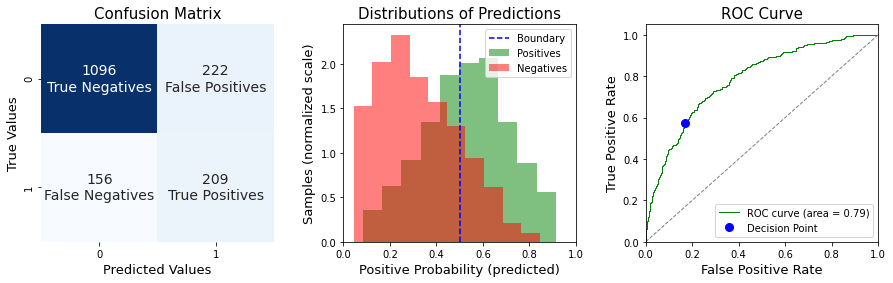

Precision: 0.48 | Recall: 0.57 | F1 Score: 0.53 | 


In [ ]:
demo_report(gr_rfc,X_val,y_val,'Validation Set Confusion Matrix')

### XGBoost

In [ ]:
from sklearn.pipeline import Pipeline
import xgboost as xgb

pipe2 = Pipeline(steps=[
    ('ordinal',OrdinalEncoder(cols=ordinal_new) ),
    ('imputing',SimpleImputer()), 
    ('scalar',StandardScaler()),
    ('xgboost',xgb.XGBClassifier(class_weight=class_weights))
])

In [ ]:
#create the grid
#CatBoostClassifier(class_weights=class_weights)
#model = xgb.XGBClassifier()

params = {
    'xgboost__max_depth': [2, 3, 5, 7, 10],
    'xgboost__n_estimators': [10, 50],
    'xgboost__learning_rate' : [0.1,0.2] 
}


#Instantiate GridSearchCV
xgcv = GridSearchCV (pipe2, 
                     param_grid =params,
                     scoring ='f1', cv= 3,
                     verbose=1,
                     n_jobs=-1)


In [ ]:
#fit the model
xgcv.fit(X_train,y_train)

#returns the estimator with the best performance
print(xgcv.best_estimator_)

#returns the best score
print(xgcv.best_score_)

#returns the best parameters
print(xgcv.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   34.8s finished


Pipeline(memory=None,
         steps=[('ordinal',
                 OrdinalEncoder(cols=['turnover_cat', 'majorcat_cat', 'sex_cat',
                                      'ind_cat', 'biz_worker_cat',
                                      'biztype_cat', 'regular_cat',
                                      'voluntary_cat', 'shift_cat',
                                      'pension_cat', 'payed_vc_cat',
                                      'maternitylv_cat', 'overtime_pay_cat',
                                      'bonus_cat', 'weely_hl_cat',
                                      'baby_vc_cat', 'wage_type_cat',
                                      'adjust_difficulty_cat', 'job_offer_cat',
                                      'gra...
                                             1: 2.316242257398486},
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.2,
                               max_del

In [ ]:
from sklearn.metrics import classification_report
gr_xgb = xgcv.best_estimator_
y_pred_xgb = gr_xgb.predict(X_val)
y_pred_proba_xgb= gr_xgb.predict_proba(X_val)[:,1]
print(classification_report(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1318
           1       0.58      0.35      0.44       365

    accuracy                           0.80      1683
   macro avg       0.71      0.64      0.66      1683
weighted avg       0.78      0.80      0.78      1683



--------------------------------------------------
Classification Report: Validation Set Confusion Matrix
--------------------------------------------------


              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1318
           1       0.58      0.35      0.44       365

    accuracy                           0.80      1683
   macro avg       0.71      0.64      0.66      1683
weighted avg       0.78      0.80      0.78      1683

--------------------------------------------------
--------------------------------------------------
Confusion Matrix & Roc Curve
--------------------------------------------------


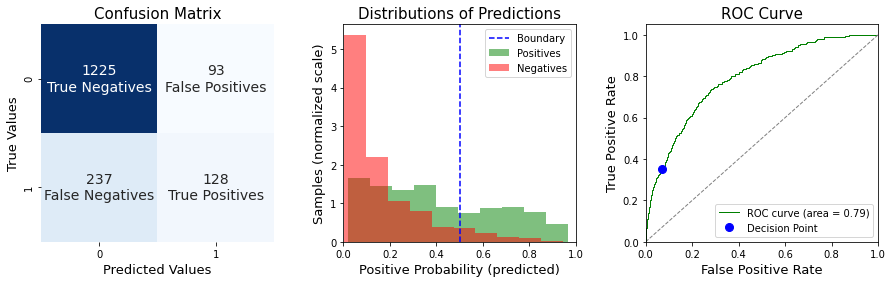

Precision: 0.58 | Recall: 0.35 | F1 Score: 0.44 | 


In [ ]:
demo_report(gr_xgb,X_val,y_val,'Validation Set Confusion Matrix')

In [ ]:
#from sklearn.model_selection import cross_validate
#cv_scores = cross_validate(pipe2, X_train, y_train, 
 #                          cv=5,
 #                           scoring=['accuracy', 'roc_auc','f1'],
 #                           return_train_score=True)

In [ ]:
cv_scores_df=pd.DataFrame(cv_scores)

print("Cross-validation 훈련_정확도: %f" % cv_scores_df.train_accuracy.mean())
print("Cross-validation 훈련_AUC: %f" % cv_scores_df.train_roc_auc.mean())
print("Cross-validation val_accuracy: %f" % cv_scores_df.test_accuracy.mean())
print("Cross-validation val_auc: %f" % cv_scores_df.test_roc_auc.mean())

Cross-validation 훈련_정확도: 0.942431
Cross-validation 훈련_AUC: 0.990828
Cross-validation val_accuracy: 0.784873
Cross-validation val_auc: 0.806567


In [ ]:
# 범주형 처리할 피쳐 설정
# ordinal 할 피처
ordinal = ['biz_worker_cat','parent_asset_cat']

# onehot 할 피처
onehot = [col for col in fin_df if col.endswith('cat') ] 

onehot = [col for col in onehot if col not in ordinal ]

# new_ordinal
ordinal_new = [col for col in fin_df if col.endswith('cat') ] 

In [ ]:
# pipe_processing
pipe4 = Pipeline(steps=[
    ('onehot',OneHotEncoder(use_cat_names=True,cols=onehot)),
    ('ordinal',OrdinalEncoder(cols=ordinal) 
])

In [ ]:
X_val_new = pipe4.fit_transform(X_val)

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = grcv.predict_proba(X_val)[:, 1]
# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.915011
1,0.000000,0.002740,0.915011
2,0.000000,0.030137,0.850495
3,0.000759,0.030137,0.845168
4,0.000759,0.054795,0.823617
...,...,...,...
459,0.891502,0.994521,0.119475
460,0.891502,0.997260,0.119096
461,0.975721,0.997260,0.083587
462,0.975721,1.000000,0.082160


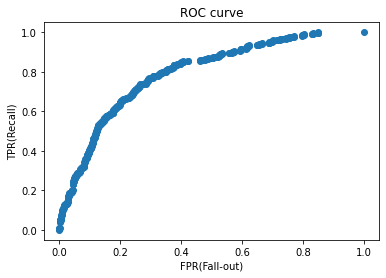

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [ ]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 306 , threshold: 0.20429780943789086


In [ ]:
from sklearn.metrics import classification_report
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1314
           1       0.42      0.77      0.54       369

    accuracy                           0.72      1683
   macro avg       0.67      0.74      0.67      1683
weighted avg       0.81      0.72      0.74      1683



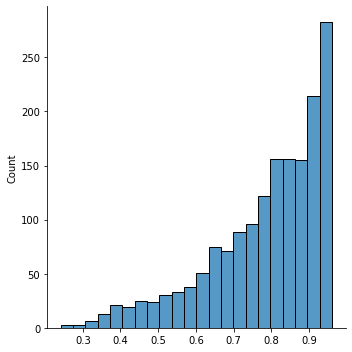

In [ ]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred_proba

sns.displot(y_pred_proba);

In [ ]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.7958351973503488

### 테스트스코어 점수 확인

RandomForest가 상대적으로 높게 나온다.

In [ ]:
# 이 곳에 답안을 작성하십시오
X_test = test
y_pred_gr_xgb = gr_xgb.predict(X_test)
y_pred_gr_rfc= gr_rfc.predict(X_test)

print('테스트세트 f1_score', f1_score(test_t,y_pred_gr_xgb))
print('테스트세트 f1_score', f1_score(test_t,y_pred_gr_rfc))


테스트세트 f1_score 0.3532846715328467
테스트세트 f1_score 0.4942408376963351


In [ ]:
gr_rfc.named_steps

{'preprocessing': Pipeline(memory=None,
          steps=[('onehotencoder',
                  OneHotEncoder(cols=['turnover_cat', 'majorcat_cat', 'sex_cat',
                                      'ind_cat', 'biztype_cat', 'regular_cat',
                                      'voluntary_cat', 'shift_cat',
                                      'pension_cat', 'payed_vc_cat',
                                      'maternitylv_cat', 'overtime_pay_cat',
                                      'bonus_cat', 'weely_hl_cat', 'baby_vc_cat',
                                      'wage_type_cat', 'adjust_difficulty_cat',
                                      'job_offer_cat', 'graduate_cat',
                                      '...
                                          {'col': 'parent_asset_cat',
                                           'data_type': dtype('int64'),
                                           'mapping':  1.0    1
  3.0    2
  2.0    3
  4.0    4
  5.0    5
  6.0    6
 -1.0    7
  7

In [ ]:
#

### 피쳐 중요도 확인

In [ ]:
# Permutation importance 계산

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    gr_rfc.named_steps['rf'], # model
    scoring='f1', #
    n_iter=5, # 
    random_state=42
)

X_val_transformed = gr_rfc.named_steps['preprocessing'].transform(X_val)


permuter.fit(X_val_transformed, y_val);

In [ ]:
# print feature importance
X_names = X_val_transformed.columns.tolist()


In [ ]:
X_val_transformed = gr_rfc.named_steps['preprocessing'].transform(X_val)
X_train_transformed = gr_rfc.named_steps['preprocessing'].transform(X_train)


In [ ]:
#feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, X_names).sort_values()

weely_hl_cat_3.0       -0.003022
baby_vc_cat_3.0        -0.001454
weely_hl_cat_1.0       -0.001187
overtime_pay_cat_1.0   -0.001103
sat_stable_num         -0.001014
                          ...   
work_time_num           0.011895
job_offer_cat_2.0       0.017714
biz_sat                 0.018837
job_offer_cat_1.0       0.025529
sat_general_num         0.030952
Length: 158, dtype: float64

In [ ]:
dd=eli5.show_weights(
    permuter, 
    top=30, # top n 지정 가능, None 일 경우 모든 특성 s
    feature_names=X_names
)

In [ ]:
dd

Weight,Feature
0.0310 ± 0.0098,sat_general_num
0.0255 ± 0.0135,job_offer_cat_1.0
0.0188 ± 0.0150,biz_sat
0.0177 ± 0.0080,job_offer_cat_2.0
0.0119 ± 0.0085,work_time_num
0.0111 ± 0.0077,sat_wage_num
0.0108 ± 0.0071,skill-fit_num
0.0093 ± 0.0056,sat_fit_num
0.0089 ± 0.0044,sat_rep2_num
0.0088 ± 0.0038,lifesat_group


In [ ]:
# 중요하지 않은 특성 삭제
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features_new = X_train_transformed.columns[mask]
X_train_selected = X_train_transformed[features_new]
X_val_selected = X_val_transformed[features_new]

In [ ]:
print('특성 삭제 전:', X_train_transformed.shape, X_val_transformed.shape)

특성 삭제 전: (6731, 158) (1683, 158)


In [ ]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (6731, 77) (1683, 77)


In [ ]:
pipe_fin = Pipeline([
    ('rf', RandomForestClassifier(class_weight=class_weights)) 
])

In [ ]:
grcv_fin = GridSearchCV(
    pipe_fin, 
    param_grid=param_dists, 
    cv=5, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

In [ ]:
# 다시 피팅
grcv_fin.fit(X_train_selected ,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   26.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight={0: 0.637646835922698,
                                                                             1: 2.316242257398486},
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                  

In [ ]:
# 최종 모델
from sklearn.metrics import classification_report
gr_rfc_fin = grcv_fin.best_estimator_
y_pred_rfc_fin = gr_rfc.predict(X_val)
y_pred_proba_rfc_fin = gr_rfc.predict_proba(X_val)[:,1]
print(classification_report(y_val, y_pred_rfc_fin))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1318
           1       0.49      0.62      0.55       365

    accuracy                           0.78      1683
   macro avg       0.69      0.72      0.70      1683
weighted avg       0.80      0.78      0.79      1683



### 특정 피처가 타겟 변수에 미치는 영향

#### 질문 : 출퇴근에 걸리는 시간의 길이는 이직준비여부에 어떤 영향을 미치는가?

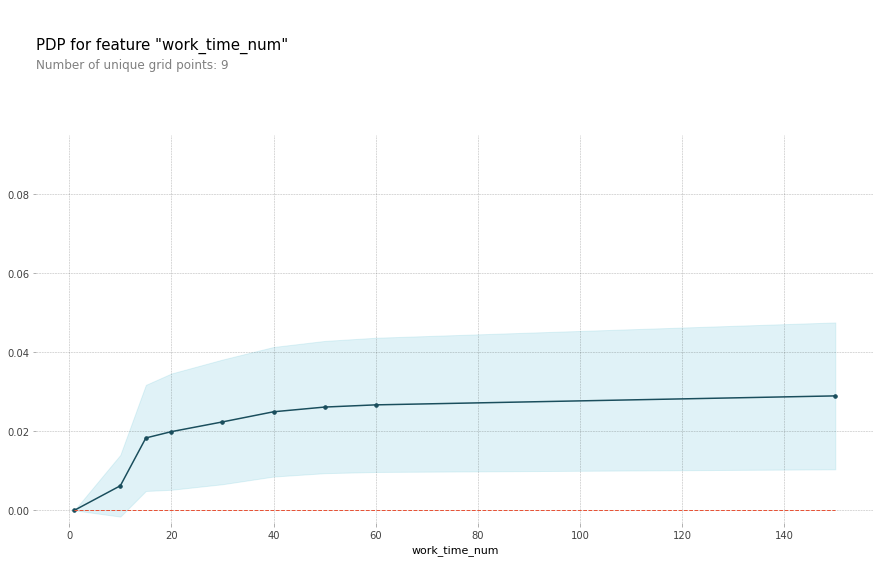

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.font_manager

# 관심특성 : 출근시간
selected_feature = 'work_time_num'

isolated = pdp_isolate(
    model=grcv_fin, 
    dataset=X_val_selected, 
    model_features=X_train_selected.columns, 
    feature=selected_feature,
)
pdp_plot(isolated, feature_name=selected_feature);

#### 질문 : 회사에서 제공되는 복지혜택의 수는 이직준비여부에 어떤 영향을 미치는 가?

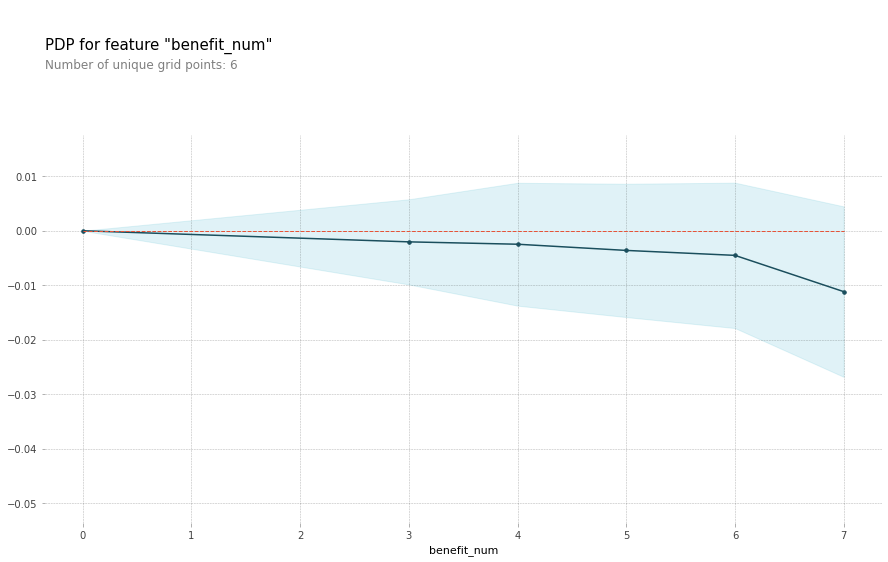

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.font_manager

# 관심특성 : 복지혜택의 수
selected_feature = 'benefit_num'

isolated = pdp_isolate(
    model=grcv_fin, 
    dataset=X_val_selected, 
    model_features=X_train_selected.columns, 
    feature=selected_feature,
)
pdp_plot(isolated, feature_name=selected_feature);

In [ ]:
X_train_selected.columns

Index(['id', 'turnover_num', 'turnover_cat_1.0', 'majorcat_cat_6.0',
       'majorcat_cat_3.0', 'majorcat_cat_5.0', 'majorcat_cat_7.0',
       'sex_cat_2.0', 'sex_cat_1.0', 'birth_date', 'age_num', 'graduy_date',
       'year_start_date', 'month_start_date', 'ind_cat_13.0', 'ind_cat_3.0',
       'ind_cat_10.0', 'biz_worker_cat', 'tw_hour', 'tw_min', 'workday_num',
       'worktime_ex_num', 'biztype_cat_1.0', 'regular_cat_2.0',
       'voluntary_cat_2.0', 'shift_cat_2.0', 'shift_cat_1.0',
       'maternitylv_cat_1.0', 'maternitylv_cat_3.0', 'bonus_cat_1.0',
       'baby_vc_cat_2.0', 'wage_type_cat_2.0', 'month_wage_num',
       'sat_wage_num', 'sat_work_num', 'sat_potential_num', 'sat_welfare_num',
       'sat_hr_num', 'sat_rep1_num', 'sat_rep2_num', 'sat_fit_num',
       'sat_edu_num', 'sat_general_num', 'sat_work-general_num', 'edu-fit_num',
       'skill-fit_num', 'major-fit_num', 'major_help_num', 'ins_1_num',
       'ins_2_num', 'ins_5_num', 'seeking_time_num',
       'adjust_diffi

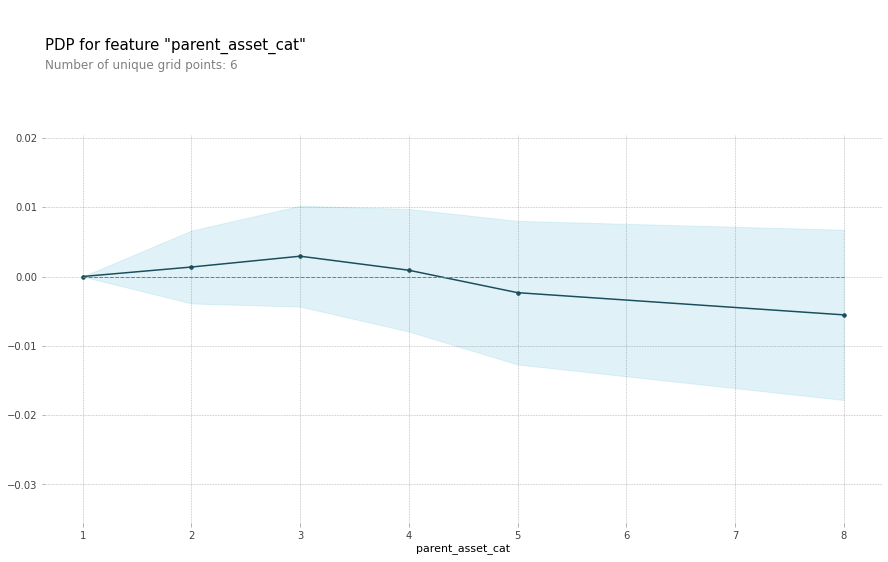

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.font_manager

# 관심특성 : 출근시간
selected_feature = 'parent_asset_cat'

isolated = pdp_isolate(
    model=grcv_fin, 
    dataset=X_val_selected, 
    model_features=X_train_selected.columns, 
    feature=selected_feature,
)
pdp_plot(isolated, feature_name=selected_feature);

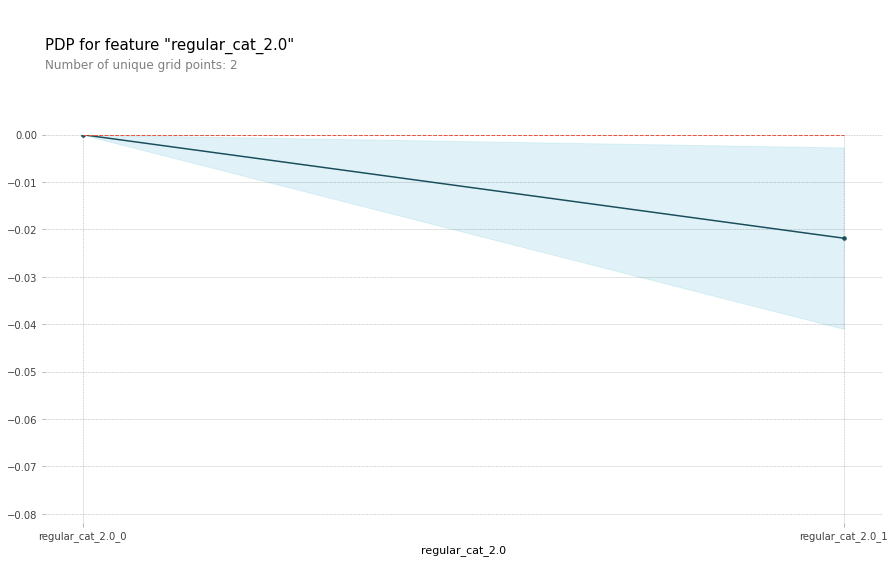

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.font_manager

# 관심특성 : 정규직
selected_feature = 'regular_cat_2.0'

isolated = pdp_isolate(
    model=grcv_fin, 
    dataset=X_val_selected, 
    model_features=X_train_selected.columns, 
    feature=selected_feature,
)
pdp_plot(isolated, feature_name=selected_feature);

#### 질문 : 이전에 다닌 직장의 수가 이직준비여부에 영향을 미치는가?

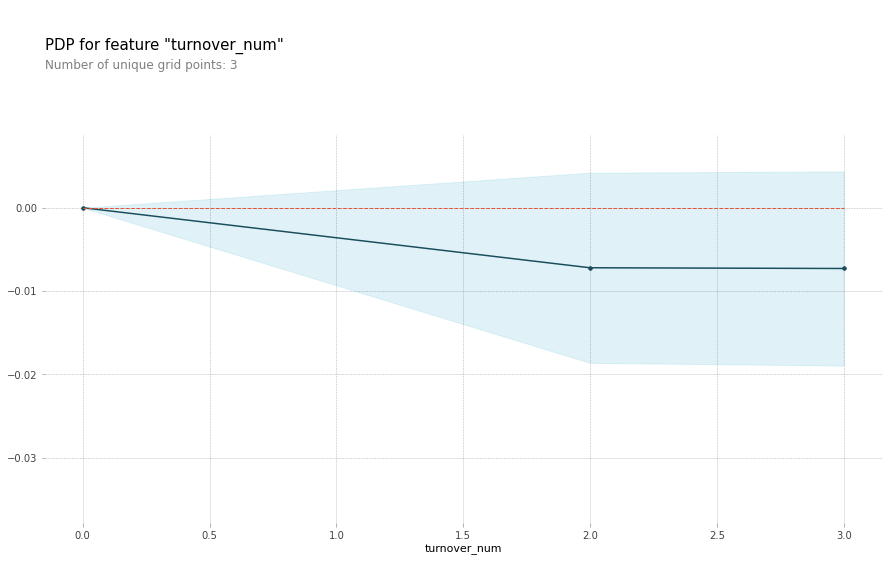

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.font_manager

# 관심특성 : 
selected_feature = 'turnover_num'

isolated = pdp_isolate(
    model=grcv_fin, 
    dataset=X_val_selected, 
    model_features=X_train_selected.columns, 
    feature=selected_feature,
)
pdp_plot(isolated, feature_name=selected_feature);

학습시간은 줄었지만 F1스코어가 드라마틱하게 나아지진 않았다.

## References

- Carr, J. C., Boyar, S. L., & Gregory, B. T. (2008). The moderating effect of work-family centrality on work-family conflict, organizational attitudes, and turnover behavior. Journal of Management, 34(2), 244–262. https://doi.org/10.1177/0149206307309262 # 이직의도->이직

- AK, Belete. (2018). Turnover Intention Influencing Factors of Employees: An Empirical Work Review. Journal of Entrepreneurship & Organization Management.